# Neurosymbolic Software Tutorial - NEAR Bouncing Ball

<a target="_blank" href="https://colab.research.google.com/github/kavigupta/neurosym-lib/blob/main/tutorial/discrete_exercise_solutions.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Instruction
- Navigating this notebook on Google Colab: There will be text blocks and code blocks throughout the notebook. The text blocks, such as this one, will contain instructions and questions for you to consider. The code blocks, such as the one below, will contain executible code. Sometimes you will have to modify the code blocks following the instructions in the text blocks. You can run the code block by either pressing control/cmd + enter or by clicking the arrow on left-hand side.
- Saving Work: If you wish to save your work in this .ipynb, we recommend downloading the compressed repository from GitHub, unzipping it, uploading it to Google Drive, and opening this notebook from within Google Drive.

## Notebook

In this notebook, you will construct a DSL to simulate a bouncing ball

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import logging
import os

import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
import torch.nn as nn

import neurosym as ns
from neurosym.examples import near
from neurosym.examples.near.operations.basic import ite_torch
from neurosym.examples.near.operations.lists import map_torch

from neurosym.datasets.load_data import DatasetFromNpy, DatasetWrapper

## Data

We then load and plot some bouncing ball trajectories. Note that these trajectories are represented as a list `[x, y, vx, vy]`

In [2]:
dataset_factory = lambda train_seed: DatasetWrapper(
    DatasetFromNpy(
        f"bouncing_ball_exercise/data/bounce_example/train_ex_data.npy",
        f"bouncing_ball_exercise/data/bounce_example/train_ex_labels.npy",
        train_seed,
    ),
    DatasetFromNpy(
        f"bouncing_ball_exercise/data/bounce_example/test_ex_data.npy",
        f"bouncing_ball_exercise/data/bounce_example/test_ex_labels.npy",
        None,
    ),
    batch_size=200,
)
datamodule = dataset_factory(42)

In [3]:
def plot_trajectory(trajectory, color):
    plt.scatter(trajectory[:, 0], trajectory[:, 1], marker="o", color=color)
    plt.plot(trajectory[:, 0], trajectory[:, 1], alpha=0.2, color=color)
    plt.xlim(-5, 10)
    plt.ylim(-5, 7)
    plt.grid(True)

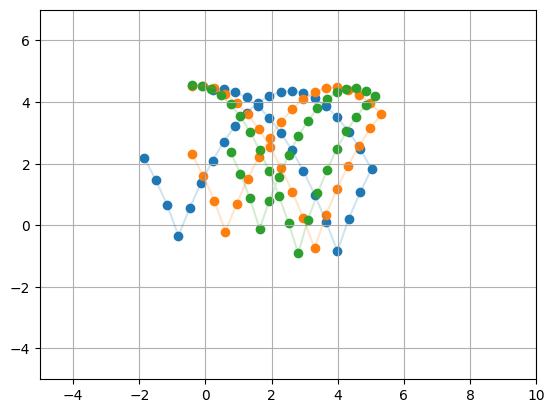

In [4]:
for i in range(3):
    plot_trajectory(datamodule.train.inputs[i], f"C{i}")

In [5]:
print("input[0] :", datamodule.train.inputs[i, 0])
print("output[0]:", datamodule.train.outputs[i, 0])

input[0] : [-0.40642968  4.5408607   2.9196808  -0.05576635]
output[0]: [-0.11446159  4.535284    2.9196808  -1.0357664 ]


## Exercise: DSL

Fill in the `bounce_dsl` to parameterize the space of functions that could represent the trajectories of bouncing balls.

In [6]:
def bounce_dsl():
    L = 4
    O = 4
    dslf = ns.DSLFactory(L=L, O=O, max_overall_depth=5)
    # BEGIN SOLUTION "YOUR CODE HERE"
    ## DSL for the bounce example.
    dslf.typedef("fL", "{f, $L}")

    dslf.parameterized(
        "linear_bool",
        "() -> $fL -> f",
        lambda lin: lin,
        dict(lin=lambda: nn.Linear(L, 1)),
    )
    dslf.parameterized(
        "linear", "() -> $fL -> $fL", lambda lin: lin, dict(lin=lambda: nn.Linear(L, L))
    )

    dslf.concrete("ite", "(#a -> f, #a -> #a, #a -> #a) -> #a -> #a", ite_torch)
    dslf.concrete(
        "map", "(#a -> #b) -> [#a] -> [#b]", lambda f: lambda x: map_torch(f, x)
    )
    # END SOLUTION
    dslf.prune_to("[$fL] -> [$fL]")
    return dslf.finalize()

In [7]:
dsl = bounce_dsl()

### DSL Printout

See your DSL printed below, and ensure it is what you would expect

In [8]:
print(dsl.render())

            ite :: (#a -> f, #a -> #a, #a -> #a) -> #a -> #a
            map :: (#a -> #b) -> [#a] -> [#b]
linear_bool[lin] :: () -> {f, 4} -> f
    linear[lin] :: () -> {f, 4} -> {f, 4}


### Setting up Neural DSL

In [9]:
input_dim, output_dim = 4, 4
t = ns.TypeDefiner(L=input_dim, O=output_dim)
t.typedef("fL", "{f, $L}")
neural_dsl = near.NeuralDSL.from_dsl(
    dsl=dsl,
    modules={
        **near.create_modules(
            "mlp",
            [t("($fL) -> $fL")],
            near.mlp_factory(hidden_size=10),
        ),
        **near.create_modules(
            "rnn_seq2seq",
            [t("([$fL]) -> [$fL]")],
            near.rnn_factory_seq2seq(hidden_size=10),
        ),
    },
)
logging.getLogger("pytorch_lightning.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("pytorch_lightning.accelerators.cuda").setLevel(logging.WARNING)


trainer_cfg = near.NEARTrainerConfig(
    lr=5e-3,
    max_seq_len=300,
    n_epochs=100,
    num_labels=output_dim,
    train_steps=len(datamodule.train),
    loss_callback=torch.nn.functional.mse_loss,
    scheduler="cosine",
    optimizer=torch.optim.Adam,
)

validation_cost = near.ValidationCost(
    neural_dsl=neural_dsl,
    trainer_cfg=trainer_cfg,
    datamodule=datamodule,
    callbacks=[
        pl.callbacks.EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5)
    ],
    enable_progress_bar=False,
    progress_by_epoch=True,
)

g = near.near_graph(
    neural_dsl,
    ns.parse_type(
        s="([{f, $L}]) -> [{f, $O}]", env=ns.TypeDefiner(L=input_dim, O=output_dim)
    ),
    is_goal=neural_dsl.program_has_no_holes,
)


### Run NEAR

In [10]:
iterator = ns.search.bounded_astar(g, validation_cost, max_depth=16)
best_program_nodes = []
# Let's collect the top four programs
while len(best_program_nodes) <= 3:
    try:
        node = next(iterator)
        cost = validation_cost(node)
        best_program_nodes.append((node, cost))
        print("Got another program")
    except StopIteration:
        print("No more programs found.")
        break

training ??::<[{f, 4}] -> [{f, 4}]>


Training:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name  | Type       | Params
-------------------------------------
0 | model | Seq2SeqRNN | 204   
-------------------------------------
204       Trainable params
0         Non-trainable params
204       Total params
0.001     Total estimated model params size (MB)


training (ite ??::<[{f, 4}] -> f> ??::<[{f, 4}] -> [{f, 4}]> ??::<[{f, 4}] -> [{f, 4}]>)


Training:   0%|          | 0/100 [00:00<?, ?it/s]

training (map ??::<{f, 4} -> {f, 4}>)


Training:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name  | Type               | Params
---------------------------------------------
0 | model | TorchProgramModule | 94    
---------------------------------------------
94        Trainable params
0         Non-trainable params
94        Total params
0.000     Total estimated model params size (MB)


training (__neural_dsl_internal_rnn_seq2seq_1)


Training:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name  | Type       | Params
-------------------------------------
0 | model | Seq2SeqRNN | 204   
-------------------------------------
204       Trainable params
0         Non-trainable params
204       Total params
0.001     Total estimated model params size (MB)


training (map (ite ??::<{f, 4} -> f> ??::<{f, 4} -> {f, 4}> ??::<{f, 4} -> {f, 4}>))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

training (map (linear))


Training:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name  | Type               | Params
---------------------------------------------
0 | model | TorchProgramModule | 20    
---------------------------------------------
20        Trainable params
0         Non-trainable params
20        Total params
0.000     Total estimated model params size (MB)


training (map (__neural_dsl_internal_mlp_1))


Training:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name  | Type               | Params
---------------------------------------------
0 | model | TorchProgramModule | 94    
---------------------------------------------
94        Trainable params
0         Non-trainable params
94        Total params
0.000     Total estimated model params size (MB)


training (map (linear))


Training:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name  | Type               | Params
---------------------------------------------
0 | model | TorchProgramModule | 20    
---------------------------------------------
20        Trainable params
0         Non-trainable params
20        Total params
0.000     Total estimated model params size (MB)


Got another program
training (map (ite (linear_bool) ??::<{f, 4} -> {f, 4}> ??::<{f, 4} -> {f, 4}>))


Training:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name  | Type               | Params
---------------------------------------------
0 | model | TorchProgramModule | 193   
---------------------------------------------
193       Trainable params
0         Non-trainable params
193       Total params
0.001     Total estimated model params size (MB)


training (map (ite (linear_bool) (ite ??::<{f, 4} -> f> ??::<{f, 4} -> {f, 4}> ??::<{f, 4} -> {f, 4}>) ??::<{f, 4} -> {f, 4}>))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

training (map (ite (linear_bool) (linear) ??::<{f, 4} -> {f, 4}>))


Training:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name  | Type               | Params
---------------------------------------------
0 | model | TorchProgramModule | 119   
---------------------------------------------
119       Trainable params
0         Non-trainable params
119       Total params
0.000     Total estimated model params size (MB)


training (map (ite (linear_bool) (__neural_dsl_internal_mlp_1) ??::<{f, 4} -> {f, 4}>))


Training:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name  | Type               | Params
---------------------------------------------
0 | model | TorchProgramModule | 193   
---------------------------------------------
193       Trainable params
0         Non-trainable params
193       Total params
0.001     Total estimated model params size (MB)


training (map (ite (linear_bool) (linear) (ite ??::<{f, 4} -> f> ??::<{f, 4} -> {f, 4}> ??::<{f, 4} -> {f, 4}>)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

training (map (ite (linear_bool) (linear) (linear)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name  | Type               | Params
---------------------------------------------
0 | model | TorchProgramModule | 45    
---------------------------------------------
45        Trainable params
0         Non-trainable params
45        Total params
0.000     Total estimated model params size (MB)


training (map (ite (linear_bool) (linear) (__neural_dsl_internal_mlp_1)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name  | Type               | Params
---------------------------------------------
0 | model | TorchProgramModule | 119   
---------------------------------------------
119       Trainable params
0         Non-trainable params
119       Total params
0.000     Total estimated model params size (MB)


training (map (ite (linear_bool) (linear) (linear)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name  | Type               | Params
---------------------------------------------
0 | model | TorchProgramModule | 45    
---------------------------------------------
45        Trainable params
0         Non-trainable params
45        Total params
0.000     Total estimated model params size (MB)


Got another program
training (map (ite (linear_bool) (__neural_dsl_internal_mlp_1) (ite ??::<{f, 4} -> f> ??::<{f, 4} -> {f, 4}> ??::<{f, 4} -> {f, 4}>)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

training (map (ite (linear_bool) (__neural_dsl_internal_mlp_1) (linear)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name  | Type               | Params
---------------------------------------------
0 | model | TorchProgramModule | 119   
---------------------------------------------
119       Trainable params
0         Non-trainable params
119       Total params
0.000     Total estimated model params size (MB)


training (map (ite (linear_bool) (__neural_dsl_internal_mlp_1) (__neural_dsl_internal_mlp_1)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name  | Type               | Params
---------------------------------------------
0 | model | TorchProgramModule | 193   
---------------------------------------------
193       Trainable params
0         Non-trainable params
193       Total params
0.001     Total estimated model params size (MB)


training (map (ite (linear_bool) (ite (linear_bool) ??::<{f, 4} -> {f, 4}> ??::<{f, 4} -> {f, 4}>) ??::<{f, 4} -> {f, 4}>))


Training:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name  | Type               | Params
---------------------------------------------
0 | model | TorchProgramModule | 292   
---------------------------------------------
292       Trainable params
0         Non-trainable params
292       Total params
0.001     Total estimated model params size (MB)


training (map (ite (linear_bool) (ite (linear_bool) (ite ??::<{f, 4} -> f> ??::<{f, 4} -> {f, 4}> ??::<{f, 4} -> {f, 4}>) ??::<{f, 4} -> {f, 4}>) ??::<{f, 4} -> {f, 4}>))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

training (map (ite (linear_bool) (ite (linear_bool) (linear) ??::<{f, 4} -> {f, 4}>) ??::<{f, 4} -> {f, 4}>))


Training:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name  | Type               | Params
---------------------------------------------
0 | model | TorchProgramModule | 218   
---------------------------------------------
218       Trainable params
0         Non-trainable params
218       Total params
0.001     Total estimated model params size (MB)


training (map (ite (linear_bool) (ite (linear_bool) (__neural_dsl_internal_mlp_1) ??::<{f, 4} -> {f, 4}>) ??::<{f, 4} -> {f, 4}>))


Training:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name  | Type               | Params
---------------------------------------------
0 | model | TorchProgramModule | 292   
---------------------------------------------
292       Trainable params
0         Non-trainable params
292       Total params
0.001     Total estimated model params size (MB)


training (map (ite (linear_bool) (ite (linear_bool) (linear) (ite ??::<{f, 4} -> f> ??::<{f, 4} -> {f, 4}> ??::<{f, 4} -> {f, 4}>)) ??::<{f, 4} -> {f, 4}>))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

training (map (ite (linear_bool) (ite (linear_bool) (linear) (linear)) ??::<{f, 4} -> {f, 4}>))


Training:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name  | Type               | Params
---------------------------------------------
0 | model | TorchProgramModule | 144   
---------------------------------------------
144       Trainable params
0         Non-trainable params
144       Total params
0.001     Total estimated model params size (MB)


training (map (ite (linear_bool) (ite (linear_bool) (linear) (__neural_dsl_internal_mlp_1)) ??::<{f, 4} -> {f, 4}>))


Training:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name  | Type               | Params
---------------------------------------------
0 | model | TorchProgramModule | 218   
---------------------------------------------
218       Trainable params
0         Non-trainable params
218       Total params
0.001     Total estimated model params size (MB)


training (map (ite (linear_bool) (ite (linear_bool) (linear) (linear)) (ite ??::<{f, 4} -> f> ??::<{f, 4} -> {f, 4}> ??::<{f, 4} -> {f, 4}>)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

training (map (ite (linear_bool) (ite (linear_bool) (linear) (linear)) (linear)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name  | Type               | Params
---------------------------------------------
0 | model | TorchProgramModule | 70    
---------------------------------------------
70        Trainable params
0         Non-trainable params
70        Total params
0.000     Total estimated model params size (MB)


training (map (ite (linear_bool) (ite (linear_bool) (linear) (linear)) (__neural_dsl_internal_mlp_1)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name  | Type               | Params
---------------------------------------------
0 | model | TorchProgramModule | 144   
---------------------------------------------
144       Trainable params
0         Non-trainable params
144       Total params
0.001     Total estimated model params size (MB)


training (map (ite (linear_bool) (ite (linear_bool) (linear) (linear)) (linear)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name  | Type               | Params
---------------------------------------------
0 | model | TorchProgramModule | 70    
---------------------------------------------
70        Trainable params
0         Non-trainable params
70        Total params
0.000     Total estimated model params size (MB)


Got another program
training (map (ite (linear_bool) (ite (linear_bool) (__neural_dsl_internal_mlp_1) (ite ??::<{f, 4} -> f> ??::<{f, 4} -> {f, 4}> ??::<{f, 4} -> {f, 4}>)) ??::<{f, 4} -> {f, 4}>))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

training (map (ite (linear_bool) (ite (linear_bool) (__neural_dsl_internal_mlp_1) (linear)) ??::<{f, 4} -> {f, 4}>))


Training:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name  | Type               | Params
---------------------------------------------
0 | model | TorchProgramModule | 218   
---------------------------------------------
218       Trainable params
0         Non-trainable params
218       Total params
0.001     Total estimated model params size (MB)


training (map (ite (linear_bool) (ite (linear_bool) (__neural_dsl_internal_mlp_1) (__neural_dsl_internal_mlp_1)) ??::<{f, 4} -> {f, 4}>))


Training:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name  | Type               | Params
---------------------------------------------
0 | model | TorchProgramModule | 292   
---------------------------------------------
292       Trainable params
0         Non-trainable params
292       Total params
0.001     Total estimated model params size (MB)


training (map (ite (linear_bool) (ite (linear_bool) (__neural_dsl_internal_mlp_1) (linear)) (ite ??::<{f, 4} -> f> ??::<{f, 4} -> {f, 4}> ??::<{f, 4} -> {f, 4}>)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

training (map (ite (linear_bool) (ite (linear_bool) (__neural_dsl_internal_mlp_1) (linear)) (linear)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name  | Type               | Params
---------------------------------------------
0 | model | TorchProgramModule | 144   
---------------------------------------------
144       Trainable params
0         Non-trainable params
144       Total params
0.001     Total estimated model params size (MB)


training (map (ite (linear_bool) (ite (linear_bool) (__neural_dsl_internal_mlp_1) (linear)) (__neural_dsl_internal_mlp_1)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name  | Type               | Params
---------------------------------------------
0 | model | TorchProgramModule | 218   
---------------------------------------------
218       Trainable params
0         Non-trainable params
218       Total params
0.001     Total estimated model params size (MB)


training (map (ite (linear_bool) (ite (linear_bool) (linear) (__neural_dsl_internal_mlp_1)) (ite ??::<{f, 4} -> f> ??::<{f, 4} -> {f, 4}> ??::<{f, 4} -> {f, 4}>)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

training (map (ite (linear_bool) (ite (linear_bool) (linear) (__neural_dsl_internal_mlp_1)) (linear)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name  | Type               | Params
---------------------------------------------
0 | model | TorchProgramModule | 144   
---------------------------------------------
144       Trainable params
0         Non-trainable params
144       Total params
0.001     Total estimated model params size (MB)


training (map (ite (linear_bool) (ite (linear_bool) (linear) (__neural_dsl_internal_mlp_1)) (__neural_dsl_internal_mlp_1)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name  | Type               | Params
---------------------------------------------
0 | model | TorchProgramModule | 218   
---------------------------------------------
218       Trainable params
0         Non-trainable params
218       Total params
0.001     Total estimated model params size (MB)


training (map (ite (linear_bool) (ite (linear_bool) (__neural_dsl_internal_mlp_1) (__neural_dsl_internal_mlp_1)) (ite ??::<{f, 4} -> f> ??::<{f, 4} -> {f, 4}> ??::<{f, 4} -> {f, 4}>)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

training (map (ite (linear_bool) (ite (linear_bool) (__neural_dsl_internal_mlp_1) (__neural_dsl_internal_mlp_1)) (linear)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name  | Type               | Params
---------------------------------------------
0 | model | TorchProgramModule | 218   
---------------------------------------------
218       Trainable params
0         Non-trainable params
218       Total params
0.001     Total estimated model params size (MB)


training (map (ite (linear_bool) (ite (linear_bool) (__neural_dsl_internal_mlp_1) (__neural_dsl_internal_mlp_1)) (__neural_dsl_internal_mlp_1)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name  | Type               | Params
---------------------------------------------
0 | model | TorchProgramModule | 292   
---------------------------------------------
292       Trainable params
0         Non-trainable params
292       Total params
0.001     Total estimated model params size (MB)


training (map (ite (linear_bool) (linear) (ite (linear_bool) ??::<{f, 4} -> {f, 4}> ??::<{f, 4} -> {f, 4}>)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name  | Type               | Params
---------------------------------------------
0 | model | TorchProgramModule | 218   
---------------------------------------------
218       Trainable params
0         Non-trainable params
218       Total params
0.001     Total estimated model params size (MB)


training (map (ite (linear_bool) (linear) (ite (linear_bool) (ite ??::<{f, 4} -> f> ??::<{f, 4} -> {f, 4}> ??::<{f, 4} -> {f, 4}>) ??::<{f, 4} -> {f, 4}>)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

training (map (ite (linear_bool) (linear) (ite (linear_bool) (linear) ??::<{f, 4} -> {f, 4}>)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name  | Type               | Params
---------------------------------------------
0 | model | TorchProgramModule | 144   
---------------------------------------------
144       Trainable params
0         Non-trainable params
144       Total params
0.001     Total estimated model params size (MB)


training (map (ite (linear_bool) (linear) (ite (linear_bool) (__neural_dsl_internal_mlp_1) ??::<{f, 4} -> {f, 4}>)))


Training:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name  | Type               | Params
---------------------------------------------
0 | model | TorchProgramModule | 218   
---------------------------------------------
218       Trainable params
0         Non-trainable params
218       Total params
0.001     Total estimated model params size (MB)


training (map (ite (linear_bool) (linear) (ite (linear_bool) (linear) (ite ??::<{f, 4} -> f> ??::<{f, 4} -> {f, 4}> ??::<{f, 4} -> {f, 4}>))))


Training:   0%|          | 0/100 [00:00<?, ?it/s]

training (map (ite (linear_bool) (linear) (ite (linear_bool) (linear) (linear))))


Training:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name  | Type               | Params
---------------------------------------------
0 | model | TorchProgramModule | 70    
---------------------------------------------
70        Trainable params
0         Non-trainable params
70        Total params
0.000     Total estimated model params size (MB)


training (map (ite (linear_bool) (linear) (ite (linear_bool) (linear) (__neural_dsl_internal_mlp_1))))


Training:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name  | Type               | Params
---------------------------------------------
0 | model | TorchProgramModule | 144   
---------------------------------------------
144       Trainable params
0         Non-trainable params
144       Total params
0.001     Total estimated model params size (MB)


training (map (ite (linear_bool) (linear) (ite (linear_bool) (linear) (linear))))


Training:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name  | Type               | Params
---------------------------------------------
0 | model | TorchProgramModule | 70    
---------------------------------------------
70        Trainable params
0         Non-trainable params
70        Total params
0.000     Total estimated model params size (MB)


Got another program


### Top 3 Programs

The code below assumes you found some top 3 programs and stored them in the best_program_nodes variable.

In [11]:
best_program_nodes = sorted(best_program_nodes, key=lambda x: x[1])
for i, (node, cost) in enumerate(best_program_nodes):
    print(
        "({i}) Cost: {cost:.4f}, {program}".format(
            i=i, program=ns.render_s_expression(node.program), cost=cost
        )
    )

(0) Cost: 21.0725, (map (linear))
(1) Cost: 21.5121, (map (ite (linear_bool) (ite (linear_bool) (linear) (linear)) (linear)))
(2) Cost: 24.6162, (map (ite (linear_bool) (linear) (linear)))
(3) Cost: 25.1772, (map (ite (linear_bool) (linear) (ite (linear_bool) (linear) (linear))))


The function below is set up to further fine tune the program, test it, and return a set of values produced by it.

In [17]:
def testProgram(best_program_node):
    module = near.TorchProgramModule(
        dsl=neural_dsl, program=best_program_node[0].program
    )
    pl_model = near.NEARTrainer(module, config=trainer_cfg)
    trainer = pl.Trainer(
        max_epochs=4000,
        devices="auto",
        accelerator="cpu",
        enable_checkpointing=False,
        logger=False,
        callbacks=[
            pl.callbacks.EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5)
        ],
        enable_progress_bar=False,
        progress_by_epoch=True,
    )

    trainer.fit(pl_model, datamodule.train_dataloader(), datamodule.val_dataloader())
    T = 100
    path = np.zeros((T, 4))
    X = torch.tensor(
        np.array([0.21413583, 4.4062634, 3.4344807, 0.12440437]), dtype=torch.float32
    )
    for t in range(T):
        path[t, :] = X.detach().numpy()
        Y = module(X.unsqueeze(0)).squeeze(0)
        X = Y
    return path

In [18]:
# We generate trajectories for the top 2 programs.
trajectory = testProgram(best_program_nodes[0])
trajectoryb = testProgram(best_program_nodes[1])

TypeError: Trainer.__init__() got an unexpected keyword argument 'progress_by_epoch'

## Plotting Trajectories

In [ ]:
plt.figure(figsize=(8, 8))

plot_trajectory(trajectory, "C0")
plot_trajectory(trajectoryb, "C1")
plot_trajectory(datamodule.train.inputs[0], "black")

plt.title("Bouncing ball (ground truth in black)")
plt.show()
